# Plan:

### Phase 2 will utilize the subset of women that were identified as abused in the study and compound extra features that were gleaned in a follow-up survey of these identified women.  These features will be narrowed and modeled to identify risk of being reassaulted.  This work will investigate appropriately on a compounded dataframe of our original features in addition to the new features from the follow-up survey.

### Hypothesis: From domain knowledge of this field, we predict that there will likely be significant identifiers of abuse that can be fed into a machine-learned model.

# ENVIRONMENT

In [1]:
# basic environment and custom scripts
import os
import acquire
import prepare
import explore
import time

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np


# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for feature selection
import xgboost as xgb

# sklearn machine learning
from sklearn.linear_model import SGDClassifier
# classification reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# SVM
from sklearn.svm import SVC
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Dimensionality
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# cross-validation, grid-search
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# visualization for tree model:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

# to explode the DataFrames and avoid truncation
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# ACQUISITION

In [2]:
# utilize acquire script to get primary dataframe for analysis
dfa, dfb = acquire.get_data()

# PREPARATION

## We will push forward and prepare dfa as we did in Phase 1.  Details and checks may be examined in the Phase 1 notebook

In [3]:
# create recidivism column
dfa['RECID'] = dfa.CASEID.apply(prepare.get_repeat_case)
# use prepare function to rename features 
dfa = prepare.rename_columns_all(dfa)
# use prepare function to re-encode data
prepare.replace_nonvals_all(dfa)

In [4]:
#peek at dfb
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


In [5]:
# formally check that there are no nulls in dataframe b
prepare.get_nulls_by_column(dfb)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [6]:
# check no 2
if not prepare.get_nulls_by_row(dfb):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(dfb)

no nulls!


In [7]:
prepare.summarize_data(dfb)

HEAD
   CASEID  M5FIRED  M11HIGH  M35SAFE  M41ILLGL  M42DAGRR  M13TALKR  M32OTHER  \
0  108395     9999        2        1         2         0         1        99   
1  108397     9999        2        1         2         0         1        99   
2  108399     9999        2        1         2         0         1        99   
3  108443     9999        2        1         2         0         1        13   
4  108444     9999        1        1         2         0         1        99   

   M27HOW  M30ARRES    ...     FORCEDR  MISCARR  RESTRAIN  CHOKED  NDRUNK  \
0   99999         3    ...           0        0         0       0       0   
1   99999         3    ...           0        0         0       1       2   
2   99999         3    ...           0        0         1       1       0   
3   99999         3    ...           0        0         0       1       1   
4   99999         3    ...           0        0         0       0       3   

   RDRUNK  BOTHDRUN  NDRUGS  RDRUGS  BOTHDRUG  
0  

## We can see the cases where reassault happened. There are 350 cases out of the original 705 (before the padding implemented in Phase 1). There were 497 cases of domestic violence (cases where the surveyed was identified as abused).

In [8]:
# make new dataframe out of subset of dfa where we only look at the victims of abuse
dfa_abused = dfa[dfa.abuse_past_year == 1]

In [9]:
# cursory glance at dfb
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 29 columns):
CASEID      497 non-null int64
M5FIRED     497 non-null int64
M11HIGH     497 non-null int64
M35SAFE     497 non-null int64
M41ILLGL    497 non-null int64
M42DAGRR    497 non-null int64
M13TALKR    497 non-null int64
M32OTHER    497 non-null int64
M27HOW      497 non-null int64
M30ARRES    497 non-null int64
M31HOW      497 non-null int64
M38ORDER    497 non-null int64
SEVERER     497 non-null int64
TOTINCR     497 non-null int64
THREATR     497 non-null int64
SLAPR       497 non-null int64
PUNCHR      497 non-null int64
BEATR       497 non-null int64
UWEAPON     497 non-null int64
FORCEDR     497 non-null int64
MISCARR     497 non-null int64
RESTRAIN    497 non-null int64
CHOKED      497 non-null int64
NDRUNK      497 non-null int64
RDRUNK      497 non-null int64
BOTHDRUN    497 non-null int64
NDRUGS      497 non-null int64
RDRUGS      497 non-null int64
BOTHDRUG    497 non-null in

In [10]:
# re-name columns in dfb into more readable features
dfb = prepare.rename_columns_recid(dfb)

In [11]:
# re-encode / clean values from dfb dataframe
prepare.replace_nonvals_recid(dfb)

In [12]:
# merge our dfb data onto our original phase one data set
df = dfa_abused.merge(right=dfb, on='id')

In [13]:
# isolate single abuse cases into 
single_abuse = df[df.reassault == 0]

In [14]:
single_abuse['id'] = range(999999, 999999 + len(single_abuse))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
#append the padded single assault values to our greater dataframe
df = df.append(single_abuse)

In [16]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [17]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

no nulls!


In [18]:
df.shape

(644, 73)

In [19]:
df.reassault.value_counts()

1    350
0    294
Name: reassault, dtype: int64

In [20]:
# create list of features
features = [col for col in df]
# drop features from this list that are perceived as primary key or target variable
features.remove('id')
features.remove('abuse_past_year')
features.remove('abuse_status')
features.remove('reassault')

In [21]:
features

['length_relationship',
 'partner_abusive',
 'num_abusers',
 'num_children',
 'pregnant',
 'beaten_while_pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'threat_hit',
 'threat_object',
 'push_shove',
 'slap',
 'kick_punch',
 'hit_object',
 'beaten',
 'choked',
 'threat_knife',
 'threat_gun',
 'rape_with_threat',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'threat_suicide',
 'partner_reported_child_abuse',
 'partner_arrested',
 'violence_increased',
 'severity_increased',
 'weapon_ever',
 'choked_ever',
 'rape_ever',
 'controlled_ever',
 'jealous',
 'capable_murder',
 'gun_fired',
 'anyone_high',
 'safe_place',
 'forced_illegal',
 'life_danger',
 'talk_about_it',
 'left_or_not',
 'medical_staff_helpful',
 'perp_arrested_ever',
 'police_resp',
 'order_protection',
 'level_severity',
 'num_incidents',
 'num_t

In [22]:
df.to_csv('phase2_df.csv')

In [23]:
# split train and test
X = df[features]
y = df[['reassault']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# EXPLORATION

## We will run chi-squared tests on our categorical variables in order to get a grasp of importance

In [24]:
# we will run chi-squared tests on our categorical variables in order to get a grasp of importance
sig_feats, sig_dict = explore.get_chi_squared(train_df, features, 'reassault')

length_relationship
Dependent (reject H0)
-----------------------
num_abusers
Dependent (reject H0)
-----------------------
beaten_while_pregnant
Dependent (reject H0)
-----------------------
support_score
Dependent (reject H0)
-----------------------
jealous_past_year
Dependent (reject H0)
-----------------------
limit_family_contact
Dependent (reject H0)
-----------------------
location_tracking
Dependent (reject H0)
-----------------------
threat_hit
Dependent (reject H0)
-----------------------
threat_object
Dependent (reject H0)
-----------------------
push_shove
Dependent (reject H0)
-----------------------
slap
Dependent (reject H0)
-----------------------
kick_punch
Dependent (reject H0)
-----------------------
hit_object
Dependent (reject H0)
-----------------------
beaten
Dependent (reject H0)
-----------------------
choked
Dependent (reject H0)
-----------------------
threat_knife
Dependent (reject H0)
-----------------------
threat_gun
Dependent (reject H0)
----------------

In [25]:
# scale continuous variables
scaler = MinMaxScaler()

scaler.fit(train_df[['id_age']])

train_df[['id_age']] = scaler.transform(train_df[['id_age']])
test_df[['id_age']] = scaler.transform(test_df[['id_age']])

In [26]:
continuous_vars = ['id_age']

In [27]:
sig_feats_c, sig_dict_c = explore.get_significant_t_tests(train_df, ['id_age'], 'reassault')

In [28]:
# call function that combines significant features from dictionaries created in statistical tests if both generated results
# otherwise make list of features just from whichever (t test or chi squared) produced significant results
if sig_feats_c and sig_feats:
    features = explore.combine_significants(sig_dict, sig_dict_c)
elif sig_feats_c:
    features = [item[0] for item in explore.sort_sigs(sig_dict_c)]
elif sig_feats:
    features = [item[0] for item in explore.sort_sigs(sig_dict)]

In [29]:
features.remove('num_incidents')

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


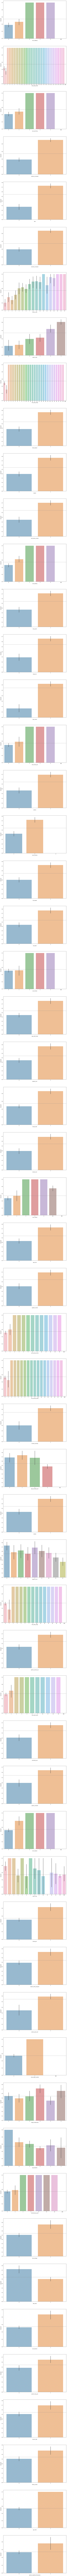

In [30]:
explore.make_bars(train_df, 'reassault', features)

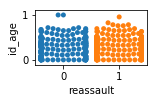

In [31]:
explore.swarrrm(train_df, 'reassault', ['id_age'])

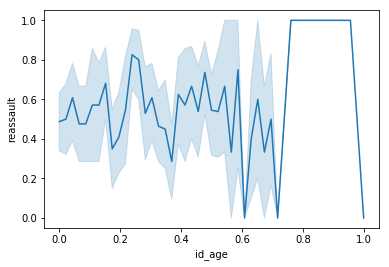

In [32]:
for feature in continuous_vars:
    sns.lineplot(x=feature, y='reassault', data=train_df)
    plt.show()

In [33]:
# histograms
# normalization(?)
# explore.plot_hist(train_df)

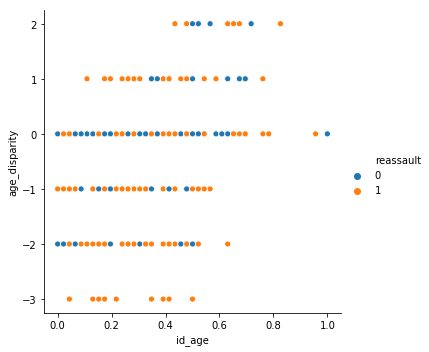

In [34]:
explore.make_rel(train_df, 'id_age', 'age_disparity', hue='reassault')

# Modeling:

### We will attempt several different tactics and models as a means to find the best fit for our data set.  We will try with various features and par down with what we found as being statistically significant through chi-squared testing.

In [35]:
features

['num_slapping',
 'num_perp_drunk',
 'num_punching',
 'violence_increased',
 'slap',
 'severity_increased',
 'harass_scale',
 'power_scale',
 'num_perp_drugs',
 'threat_object',
 'beaten',
 'limit_family_contact',
 'num_beating',
 'kick_punch',
 'threat_hit',
 'push_shove',
 'num_forced_sex',
 'jealous',
 'level_severity',
 'life_danger',
 'hit_object',
 'num_threats',
 'rape_with_threat',
 'weapon_ever',
 'threat_knife',
 'choked_ever',
 'num_choked',
 'rape_ever',
 'capable_murder',
 'num_woman_drunk',
 'num_woman_drugs',
 'location_tracking',
 'perp_arrested_ever',
 'choked',
 'support_score',
 'num_both_drugs',
 'partner_alcohol_use',
 'num_both_drunk',
 'controlled_ever',
 'partner_arrested',
 'num_weapon',
 'police_resp',
 'threat_gun',
 'beaten_while_pregnant',
 'jealous_past_year',
 'miscarriage_resulted',
 'length_relationship',
 'age_disparity',
 'restrained_by_perp',
 'forced_illegal',
 'safe_place',
 'num_abusers',
 'partner_drug_use',
 'anyone_high',
 'threat_suicide',
 'g

# Naive Bayes

In [36]:
import model
gnb_model, y_pred, y_pred_proba = model.naive_bayes(features, X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb_model.score(X_train[features], y_train)))

Accuracy of GNB classifier on training set: 0.56


In [38]:
# print raw confusion matrix:
# ~~~~~ edit this to display cleaner ~~~~~
print(confusion_matrix(y_train, y_pred))

[[ 13 237]
 [  2 295]]


In [39]:
# classification report
print(classification_report(y_train, y_pred))


             precision    recall  f1-score   support

          0       0.87      0.05      0.10       250
          1       0.55      0.99      0.71       297

avg / total       0.70      0.56      0.43       547



## Try another GNB model with a lot fewer features. These are the top 5 features of significance according to the chi squared testing.

In [40]:
features[0:5]

['num_slapping',
 'num_perp_drunk',
 'num_punching',
 'violence_increased',
 'slap']

In [41]:
gnb, y_pred, y_pred_proba = model.naive_bayes(features[0:5], X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train[features[0:5]], y_train)))

print(confusion_matrix(y_train, y_pred))


print(classification_report(y_train, y_pred))

Accuracy of GNB classifier on training set: 0.55
[[  8 242]
 [  3 294]]
             precision    recall  f1-score   support

          0       0.73      0.03      0.06       250
          1       0.55      0.99      0.71       297

avg / total       0.63      0.55      0.41       547



# The GNB model performs better with the top 5 features. It has accuracy of 93%.

## Logistic Regression w/ Cross Validation: 

In [43]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5,
                           random_state=0,
                          ).fit(X_train[features[0:8]], y_train)

y_pred = clf.predict(X_train[features[0:8]])

y_pred_proba = clf.predict_proba(X_train[features[0:8]])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
clf.score(X_train[features[0:8]], y_train) 

0.7769652650822669

In [45]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(clf.score(X_train[features[0:8]], y_train)))

Accuracy of Logistic Regression classifier on training set: 0.78


In [46]:
print(confusion_matrix(y_train, y_pred))

[[197  53]
 [ 69 228]]


In [47]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.74      0.79      0.76       250
          1       0.81      0.77      0.79       297

avg / total       0.78      0.78      0.78       547



## Decision Tree:

In [48]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

grid = GridSearchCV(dtc, params, cv=3, iid=True)

grid.fit(X_train[features[0:4]], y_train)

results = grid.cv_results_
results.keys()

test_scores = results['mean_test_score']
test_scores

params = results['params']
params

for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

dtc.fit(X_train[features[0:4]], y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [49]:
cross_val_score(dtc, X_train[features[0:4]], y_train, cv=5)

array([0.86363636, 0.85454545, 0.89908257, 0.91743119, 0.91743119])

In [50]:
y_pred = dtc.predict(X_train[features[0:4]])
y_pred[0:5]

array([0, 1, 0, 1, 1])

In [51]:
y_pred_proba = dtc.predict_proba(X_train[features[0:4]])
y_pred_proba

array([[0.83703704, 0.16296296],
       [0.36363636, 0.63636364],
       [0.83703704, 0.16296296],
       ...,
       [0.83703704, 0.16296296],
       [0.83703704, 0.16296296],
       [0.        , 1.        ]])

In [52]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train[features[0:4]], y_train)))

Accuracy of Decision Tree classifier on training set: 0.89


In [53]:
confusion_matrix(y_train, y_pred)

array([[234,  16],
       [ 44, 253]])

In [54]:
sorted(y_train.reassault.unique())

[0, 1]

In [55]:
y_train.reassault.value_counts()

1    297
0    250
Name: reassault, dtype: int64

In [56]:
confusion_matrix(y_train, y_pred)

array([[234,  16],
       [ 44, 253]])

In [57]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.94      0.89       250
          1       0.94      0.85      0.89       297

avg / total       0.90      0.89      0.89       547



In [58]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

In [59]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

In [60]:
grid = GridSearchCV(dtc, params, cv=3, iid=True)

In [61]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'max_features': [None, 1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [63]:
test_scores = results['mean_test_score']
test_scores

array([1.        , 0.68190128, 0.67458867, 1.        , 0.63619744,
       0.72943327, 1.        , 0.72760512, 0.75685558])

In [64]:
params = results['params']
params

[{'max_depth': 2, 'max_features': None},
 {'max_depth': 2, 'max_features': 1},
 {'max_depth': 2, 'max_features': 3},
 {'max_depth': 3, 'max_features': None},
 {'max_depth': 3, 'max_features': 1},
 {'max_depth': 3, 'max_features': 3},
 {'max_depth': 4, 'max_features': None},
 {'max_depth': 4, 'max_features': 1},
 {'max_depth': 4, 'max_features': 3}]

In [65]:
for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,max_depth,max_features,score
4,3,1.0,0.636197
2,2,3.0,0.674589
1,2,1.0,0.681901
7,4,1.0,0.727605
5,3,3.0,0.729433
8,4,3.0,0.756856
0,2,NaN,1.000000
3,3,NaN,1.000000
6,4,NaN,1.000000


In [66]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [67]:
cross_val_score(dtc, X_train, y_train, cv=5)

array([0.77272727, 0.78181818, 0.7706422 , 0.72477064, 0.73394495])

In [68]:
y_pred = dtc.predict(X_train)
y_pred[0:5]

array([1, 1, 0, 1, 1])

In [69]:
y_pred_proba = dtc.predict_proba(X_train)
y_pred_proba

array([[0.13084112, 0.86915888],
       [0.13084112, 0.86915888],
       [0.75268817, 0.24731183],
       ...,
       [0.92857143, 0.07142857],
       [0.83561644, 0.16438356],
       [0.33333333, 0.66666667]])

In [70]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.77


In [71]:
confusion_matrix(y_train, y_pred)

array([[163,  87],
       [ 37, 260]])

In [72]:
y_train

,reassault
243,1
124,1
299,0
76,1
448,1
351,1
437,1
577,0
213,1
159,1


In [73]:
sorted(y_train.reassault.unique())

[0, 1]

In [74]:
y_train.reassault.value_counts()

1    297
0    250
Name: reassault, dtype: int64

In [75]:
labels = sorted(y_train.reassault.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,163,87
1,37,260


In [76]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.65      0.72       250
          1       0.75      0.88      0.81       297

avg / total       0.78      0.77      0.77       547



In [77]:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus
from sklearn import preprocessing
from sklearn import tree

In [78]:
# conda install pydotplus
def plot_decision_tree(clf,feature_name,target_name):
    '''This function creates a visualization of a decision tree in png format. 
    Takes a decision tree object, feature names of the training set and a target variable for the target name.'''
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

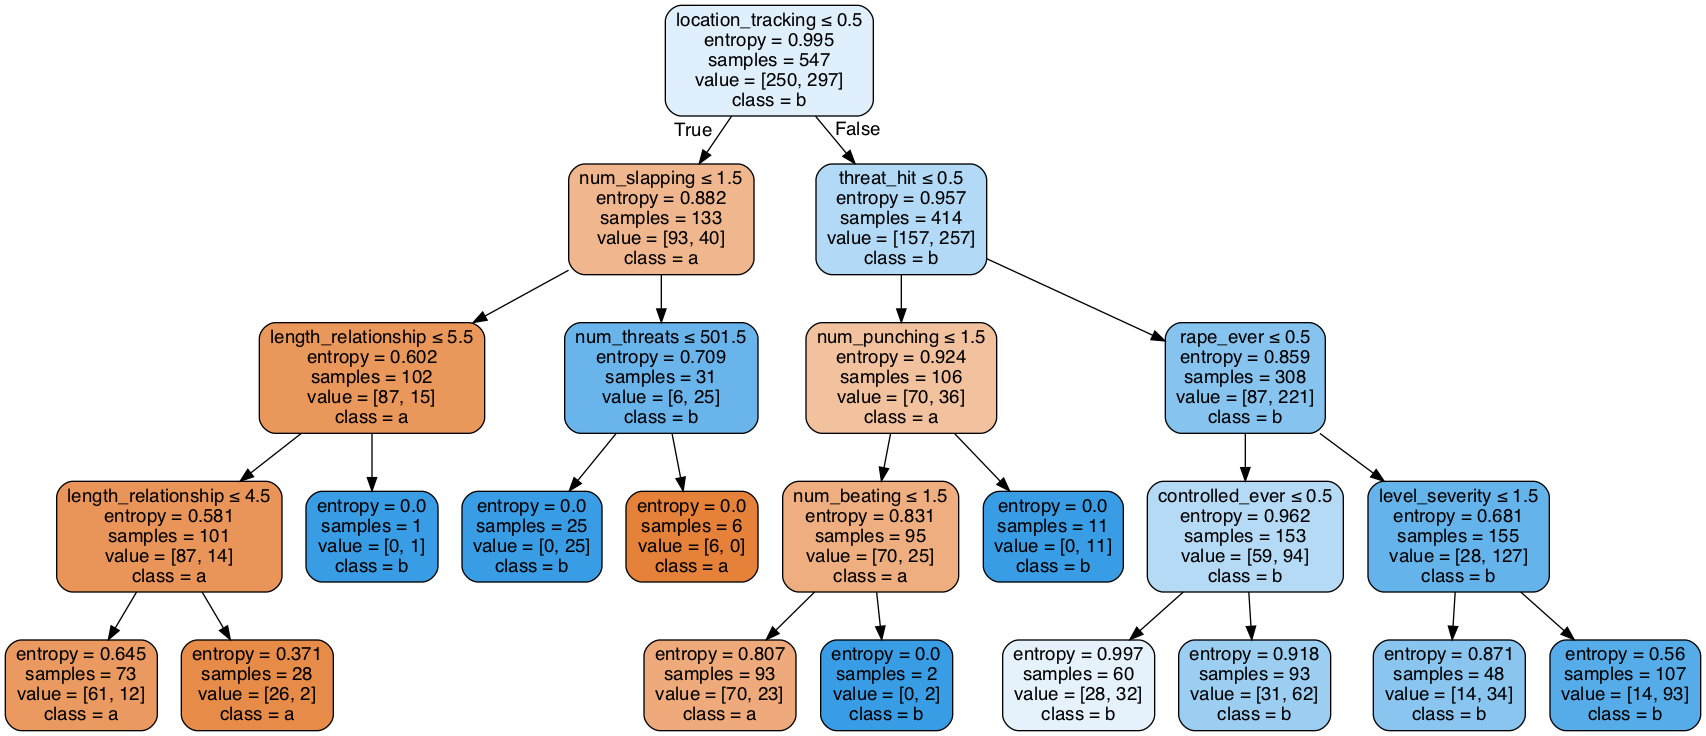

In [79]:
plot_decision_tree(dtc, X_train.columns, df.columns[1])

##  Random Forest:

In [80]:
r_params = {'max_depth': [2, 3, 4]}

In [81]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=0)

In [82]:
r_grid = GridSearchCV(rf, r_params, cv=3, iid=True)

In [83]:
r_grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarni

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [84]:
r_results = r_grid.cv_results_
r_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [85]:
r_test_scores = r_results['mean_test_score']
r_test_scores

array([0.96892139, 0.98354662, 0.98720293])

In [86]:
r_params = r_results['params']
r_params

[{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}]

In [87]:
for p, s in zip(r_params, r_test_scores):
    p['score'] = s

pd.DataFrame(r_params).sort_values(by='score')

,max_depth,score
0,2,0.968921
1,3,0.983547
2,4,0.987203


In [88]:
rf.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
cross_val_score(rf, X_train, y_train, cv=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarni

array([0.99090909, 0.95454545, 0.98165138, 1.        , 1.        ])

In [90]:
print(rf.feature_importances_)

[1.92427589e-03 0.00000000e+00 0.00000000e+00 7.00238546e-04
 0.00000000e+00 3.64744270e-03 3.33557138e-03 0.00000000e+00
 3.55471138e-04 1.11163243e-03 6.36889017e-03 1.48356199e-02
 1.22872131e-02 1.55545603e-02 3.77785323e-02 8.54814584e-03
 4.31813427e-03 1.35327653e-02 2.38225621e-03 6.39378513e-03
 0.00000000e+00 7.91916722e-03 2.07901140e-02 1.40109124e-02
 1.09719707e-03 6.41083123e-04 0.00000000e+00 0.00000000e+00
 5.00919858e-04 1.23796824e-03 8.59219496e-04 0.00000000e+00
 5.84643811e-04 6.09849945e-02 6.05114944e-02 8.31864157e-04
 1.77111086e-03 2.16823074e-03 6.27437437e-05 8.20454436e-03
 9.27223387e-05 0.00000000e+00 1.20151084e-03 9.39873229e-04
 0.00000000e+00 5.44015233e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.36415846e-03 1.32206298e-03 6.29706075e-04
 7.17633054e-03 2.87423841e-01 1.24713411e-02 1.07702774e-01
 8.48940599e-02 1.69940675e-02 4.48347420e-03 9.35098115e-03
 8.08629862e-03 6.36842322e-03 0.00000000e+00 7.53182790e-02
 7.83578447e-03 4.404720

In [91]:
y_pred = rf.predict(X_train)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,

In [92]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.24740319, 0.75259681],
       [0.18450978, 0.81549022],
       [0.7804586 , 0.2195414 ],
       ...,
       [0.83987258, 0.16012742],
       [0.81623293, 0.18376707],
       [0.16429401, 0.83570599]])

In [93]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.99


In [94]:
print(confusion_matrix(y_train, y_pred))

[[250   0]
 [  3 294]]


In [95]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       250
          1       1.00      0.99      0.99       297

avg / total       0.99      0.99      0.99       547



# ------------ DFB WORK START HERE ------------ # 

## _So now we can see the cases where reassault happened. There are 350 cases out of 705. There were 497 cases of domestic violence._

In [96]:
# make new dataframe out of subset of dfa where we only look at the victims of abuse
dfa_abused = dfa[dfa.abuse_past_year == 1]

In [97]:
df6 = acquire.read_data('data06.csv')
# df8 = acquire.read_data('data08.csv') # NO USEFUL COLUMNS
df11 = acquire.read_data('data11.csv')
# df12 = acquire.read_data('data12.csv') # NO USEFUL COLUMNS

In [98]:
six_cols = ['CASEID',
            'M11HIGH',
            'M35SAFE',
            'M41ILLGL',
            'M42DAGRR',
            'M13TALKR',
            'M32OTHER',
            'M30ARRES',
            'M31HOW',
            'M38ORDER',
           ]

eleven_cols = ['CASEID',
               'SEVERER',
               'TOTINCR',
               'THREATR',
               'SLAPR',
               'PUNCHR',
               'BEATR',
               'UWEAPON',
               'FORCEDR',
               'MISCARR',
               'RESTRAIN',
               'CHOKED',
               'NDRUNK',
               'RDRUNK',
               'BOTHDRUN',
               'NDRUGS',
               'RDRUGS',
               'BOTHDRUG',
              ]

In [99]:
# drop dataframes down to desired features
df6 = df6[six_cols]
df11 = df11[eleven_cols]

In [100]:
dfb = df6.merge(right=df11, on='CASEID')

In [101]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 27 columns):
CASEID      497 non-null int64
M11HIGH     497 non-null int64
M35SAFE     497 non-null int64
M41ILLGL    497 non-null int64
M42DAGRR    497 non-null int64
M13TALKR    497 non-null int64
M32OTHER    497 non-null int64
M30ARRES    497 non-null int64
M31HOW      497 non-null int64
M38ORDER    497 non-null int64
SEVERER     497 non-null int64
TOTINCR     497 non-null int64
THREATR     497 non-null int64
SLAPR       497 non-null int64
PUNCHR      497 non-null int64
BEATR       497 non-null int64
UWEAPON     497 non-null int64
FORCEDR     497 non-null int64
MISCARR     497 non-null int64
RESTRAIN    497 non-null int64
CHOKED      497 non-null int64
NDRUNK      497 non-null int64
RDRUNK      497 non-null int64
BOTHDRUN    497 non-null int64
NDRUGS      497 non-null int64
RDRUGS      497 non-null int64
BOTHDRUG    497 non-null int64
dtypes: int64(27)
memory usage: 108.7 KB


In [102]:
dfb = prepare.rename_columns_recid(dfb)

In [103]:
prepare.replace_nonvals_recid(dfb)

In [104]:
df = dfa_abused.merge(right=dfb, on='id')

In [105]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [106]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

no nulls!


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 71 columns):
id                              497 non-null int64
abuse_past_year                 497 non-null int64
abuse_status                    497 non-null int64
length_relationship             497 non-null int64
partner_abusive                 497 non-null int64
num_abusers                     497 non-null int64
num_children                    497 non-null int64
pregnant                        497 non-null int64
beaten_while_pregnant           497 non-null int64
support_score                   497 non-null int64
guns_in_home                    497 non-null int64
jealous_past_year               497 non-null int64
limit_family_contact            497 non-null int64
location_tracking               497 non-null int64
threat_hit                      497 non-null int64
threat_object                   497 non-null int64
push_shove                      497 non-null int64
slap                        

In [109]:
feats = [col for col in df_so_very_large]

NameError: name 'df_so_very_large' is not defined

In [ ]:
feats

In [ ]:
feats.remove('id')
feats.remove('length_relationship')
feats.remove('power_scale')
feats.remove('harass_scale')
feats.remove('id_age')
feats.remove('reassault')

In [ ]:
# split train and test
train_df, test_df = train_test_split(df_so_very_large, test_size=.15, random_state=0, stratify=df_so_very_large[['reassault']])

In [ ]:
feats

In [ ]:
sig_feats, sig_dict = explore.get_chi_squared(train_df, feats, 'reassault')

In [110]:
sig_dict

{'length_relationship': 17.208802414923273,
 'num_abusers': 12.880849034438747,
 'beaten_while_pregnant': 21.39954041540204,
 'support_score': 36.07966028987626,
 'jealous_past_year': 19.07646541783816,
 'limit_family_contact': 67.28954685399746,
 'location_tracking': 40.263607016553244,
 'threat_hit': 62.86453119447707,
 'threat_object': 76.59064587911466,
 'push_shove': 61.080449174201355,
 'slap': 108.31441244164672,
 'kick_punch': 65.15917743398968,
 'hit_object': 51.18504720420534,
 'beaten': 71.68750359903348,
 'choked': 39.582461361992685,
 'threat_knife': 48.01468214154973,
 'threat_gun': 22.46764202878945,
 'rape_with_threat': 48.667701377210115,
 'power_scale': 99.39175233279796,
 'harass_scale': 104.97383042890377,
 'age_disparity': 16.8196996208312,
 'partner_drug_use': 12.53164562237817,
 'partner_alcohol_use': 32.502588720939485,
 'threat_suicide': 10.9242005824231,
 'partner_reported_child_abuse': 4.09861129481275,
 'partner_arrested': 30.272236489847433,
 'violence_incr

In [111]:
feats = [item[0] for item in explore.sort_sigs(sig_dict)]

In [112]:
len(feats)

58

In [113]:
feats

['num_incidents',
 'num_slapping',
 'num_perp_drunk',
 'num_punching',
 'violence_increased',
 'slap',
 'severity_increased',
 'harass_scale',
 'power_scale',
 'num_perp_drugs',
 'threat_object',
 'beaten',
 'limit_family_contact',
 'num_beating',
 'kick_punch',
 'threat_hit',
 'push_shove',
 'num_forced_sex',
 'jealous',
 'level_severity',
 'life_danger',
 'hit_object',
 'num_threats',
 'rape_with_threat',
 'weapon_ever',
 'threat_knife',
 'choked_ever',
 'num_choked',
 'rape_ever',
 'capable_murder',
 'num_woman_drunk',
 'num_woman_drugs',
 'location_tracking',
 'perp_arrested_ever',
 'choked',
 'support_score',
 'num_both_drugs',
 'partner_alcohol_use',
 'num_both_drunk',
 'controlled_ever',
 'partner_arrested',
 'num_weapon',
 'police_resp',
 'threat_gun',
 'beaten_while_pregnant',
 'jealous_past_year',
 'miscarriage_resulted',
 'length_relationship',
 'age_disparity',
 'restrained_by_perp',
 'forced_illegal',
 'safe_place',
 'num_abusers',
 'partner_drug_use',
 'anyone_high',
 'th